# Counting number of the mutual friends

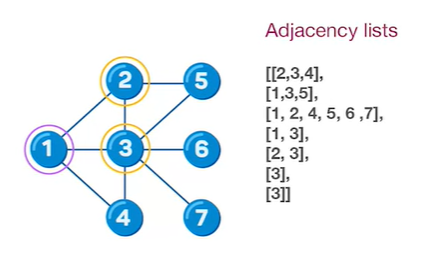

For each user having ID in the column userId count the amount of his / her common friends with each other user having ID in the column userId.

Print 49 pairs of the users having the largest amount of common friends, ordered in descending order first by the common friends count , then by id of user1 and finally by id of user 2. The format is following: "count user1 user2"7

Example:

`
234 54719 767867
120 54719 767866
97 50787 327676`

To solve this task use the algorithm described in the last video of lesson 1. The overall plan could look like this:

- Create a new column “friend” by exploding of column “friends” (like in the demo iPython notebook)
- group the resulting dataframe by the column “friend” (like in the demo iPython notebook)
- create a column “users” by collecting all users with the same id in the column “friend” together (like in the demo iPython notebook)
- sort the elements in the column “users” by the function sort_array
- filter only the rows which have more than 1 element in the column “users”
- for each row emit all possible ordered pairs of users from the column “users” (tip: write a user defined function for this)
- count the number of times each pair has appeared
- with the help of the window function (like in the demo python notebook) select 49 pairs of users who have the biggest amount of common friends

The sample dataset is located at /data/graphDFSample.

The part of the result on the sample dataset:

`...
3044 21864412 51640390
3021 17139850 51640390
3010 14985079 51640390
2970 17139850 21864412
2913 20158643 27967558
...`

### Run Spark

In [3]:
import os
execfile(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.1.1
      /_/

Using Python version 2.7.12 (default, Nov 19 2016 06:48:10)
SparkSession available as 'spark'.


### Create a Spark session

In [4]:
from pyspark.sql import SparkSession
sparkSession = SparkSession.builder.enableHiveSupport().master("local [2]").getOrCreate()

### Define a source

In [5]:
graphPath = "/data/graphDFSample"

### Read the parquet files into a dataframe

In [6]:
initialGraph = sparkSession.read.parquet(graphPath)
initialGraph.show()

+--------+--------------------+
|    user|             friends|
+--------+--------------------+
|22991438|[20699, 175973, 5...|
|37586597|[83616, 139192, 1...|
|56325000|[504270, 645333, ...|
|12862761|[234344, 5991561,...|
|38989299|[47992, 83113, 70...|
|65031716|[220980, 492159, ...|
|18094770|[139567, 149984, ...|
|43349693|[95031, 358414, 4...|
|64375823|[1190888, 2342864...|
|18360283|[660838, 1908870,...|
|37408934|[417231, 428674, ...|
|59484017|[1033204, 1573300...|
|17900561|[129522, 159136, ...|
|36381353|[354097, 1969031,...|
|54251948|[873790, 942906, ...|
| 9858863|[155794, 194964, ...|
|35436637|[520426, 587935, ...|
|52219111|[247848, 302866, ...|
|13730644|[114979, 164004, ...|
|31475110|[411231, 544632, ...|
+--------+--------------------+
only showing top 20 rows



In [22]:
initialGraph.select(count(col("user"))).show()

+-----------+
|count(user)|
+-----------+
|      49535|
+-----------+



### Print dataframe schema

In [7]:
initialGraph.printSchema()

root
 |-- user: integer (nullable = true)
 |-- friends: array (nullable = true)
 |    |-- element: integer (containsNull = true)



### Prepare reversed dataframe

In [8]:
from pyspark.sql.functions import explode, collect_list, size, col, row_number, sort_array, count, split

reversedGraph = sparkSession.read.parquet(graphPath) \
    .withColumn("friend", explode('friends')) \
    .groupBy("friend") \
    .agg(sort_array(collect_list("user")).alias("users")) \
    .filter(size("users") > 1)

In [9]:
#reversedGraph.show()

+------+--------------------+
|friend|               users|
+------+--------------------+
|   148|[3195315, 1463110...|
| 36538|[5506394, 6170161...|
| 41751|[41811068, 60873111]|
| 49331|[45058971, 58571716]|
| 73470|[37445156, 49852791]|
| 74904|[23707010, 45631379]|
| 76756|[2387712, 3274722...|
| 80033| [2065496, 33774663]|
| 84812|[49693219, 613341...|
| 89056|[48129612, 57301673]|
| 93319|[12426490, 295206...|
| 99817|[9066876, 2807348...|
|106544| [6726863, 14514274]|
|119432|[17463623, 238730...|
|120899|[49313021, 51652733]|
|130544| [2110978, 55689580]|
|132406|[6170161, 5216739...|
|137793| [5742539, 49470595]|
|149177| [4810494, 55544248]|
|162263|[35708360, 57387722]|
+------+--------------------+
only showing top 20 rows



In [21]:
reversedGraph.select(count(col("friend"))).show()

+-------------+
|count(friend)|
+-------------+
|      3018835|
+-------------+



### Prepare UDF for generate all pairs of users for particular common friend

In [15]:
import pyspark.sql.functions as f
import pyspark.sql.types as t
from itertools import combinations

def get_ordered_pairs (arr):
    #n = len(arr)
    #full_arr = [] 
    #for i in range(n):
    #    for j in range(n):
    #        if (i<j):
    #            full_arr.append([arr[i], arr[j]])
    #return full_arr
    return combinations(sorted(arr), 2)

#get_ordered_pairs_udf = f.udf(get_ordered_pairs, t.ArrayType(t.ArrayType(t.StringType())))

pair_schema = t.StructType([
    t.StructField("user1", t.IntegerType(), False),
    t.StructField("user2", t.IntegerType(), False)
])

get_ordered_pairs_udf = f.udf(get_ordered_pairs, t.ArrayType(pair_schema))

### Group pairs of users and count common friends for them

In [17]:
finalGraph = (reversedGraph.withColumn("pair_of_users", get_ordered_pairs_udf('users'))
         .withColumn("pair", explode('pair_of_users'))
         .groupBy("pair")
         .agg(count("pair").alias("pair_count"))
        ).show()

### Top 49 pair users ordered by count common friends

In [19]:
top49 = (finalGraph.select(col("pair_count"), "pair.*")
           .orderBy(col("pair_count").desc(), col("user1").desc(), col("user2").desc())
           .limit(49)
          ).collect()

In [20]:
for val in top49:
    print ('%s %s %s' % val)

3206 27967558 42973992
3130 20158643 42973992
3066 22582764 42973992
3044 21864412 51640390
3021 17139850 51640390
3010 14985079 51640390
2970 17139850 21864412
2913 20158643 27967558
2903 22280814 51151280
2870 23848749 51640390
2855 20158643 22582764
2849 20158643 44996025
2846 22280814 42973992
2784 21864412 23848749
2779 31964081 51640390
2776 39205988 51640390
2754 17139850 23848749
2749 22582764 27967558
2728 50561859 51640390
2724 15485897 51640390
2700 28135661 42973992
2655 22280814 27967558
2653 42973992 43548989
2639 26755857 51640390
2621 14635589 51640390
2608 15485897 17139850
2606 17139850 26755857
2601 21864412 39205988
2600 8406745 51640390
2599 37735419 51640390
2597 20158643 28135661
2585 40003405 42973992
2585 21864412 31964081
2581 27967558 43548989
2579 23848749 31964081
2578 27967558 28135661
2578 15485897 21864412
2577 42973992 64755069
2574 51151280 57077210
2573 20158643 43548989
2566 21864412 26755857
2564 22280814 64755069
2561 42973992 44996025
2556 1713985